# TME 7 — Dynamics of a Qubit Under Decoherence

### Bloch Sphere, Noise Channels, and Trajectories

The goal of this TME is to study the dynamics of a single qubit under:
- phase damping (characterized by the time constant $T_2$),
- amplitude damping (characterized by $T_1$),
- depolarizing noise,
- and repeated imperfect quantum gates.

All exercises gradually build toward a physical understanding of how noise affects the Bloch vector, and how different noise channels manifest as trajectories on the Bloch sphere.

We will work exclusively with **Bloch vectors**:
$$
\rho = \frac{1}{2}\left( I + \vec{r}\cdot\vec{\sigma} \right),
$$
where $\vec{r} = (x,y,z)$ and $\vec{\sigma} = (X,Y,Z)$ are the Pauli matrices.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import CSS4_COLORS
from random import choice

In [74]:
# Helper to later get a random color for a vector on the Bloch sphere (cannot be black, cyan, red, or green to avoid confusing with axes)
forbidden_colors = ['black', 'cyan', 'red', 'green']
colors = list(CSS4_COLORS.keys())

for color in forbidden_colors:
    if color in colors:
        del CSS4_COLORS[color]

colors = list(CSS4_COLORS.keys())

In [75]:
# Pauli matrices
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
I = np.array([[1, 0], [0, 1]], dtype=complex)

In [76]:
# Computational basis states
ket0 = np.array([[1], [0]], dtype=complex)
ket1 = np.array([[0], [1]], dtype=complex)
bra0 = ket0.conj().T
bra1 = ket1.conj().T

# Density matrices
rho0 = ket0 @ bra0  # |0><0|
rho1 = ket1 @ bra1  # |1><1|

In [77]:
# We define a utility function to plot the empty Bloch sphere, such that later on we can reuse it to plot some trajectories and points on it.
def bloch_sphere(ax):
    u, v = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]

    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)


    # Get rid of colored axes planes
    # First remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    # Plot the sphere surface
    ax.plot_wireframe(x, y, z, color="lightgray", alpha=0.15)

    # Add colored orthonormal axes with alpha 0.5
    alpha = 0.5
    ax.quiver(0,0,0,1,0,0,color='r',linewidth=2, arrow_length_ratio=0.1, alpha=alpha)
    ax.quiver(0,0,0,0,1,0,color='g',linewidth=2, arrow_length_ratio=0.1, alpha=alpha)
    ax.quiver(0,0,0,0,0,1,color='cyan',linewidth=2, arrow_length_ratio=0.1, alpha=alpha)
    ax.text(1.2, 0, 0, 'X', color='r', fontsize=18, alpha=0.6)  # Red for X
    ax.text(0, 1.2, 0, 'Y', color='g', fontsize=18, alpha=0.6)  # Green for Y
    ax.text(0, 0, 1.2, 'Z', color='cyan', fontsize=18, alpha=0.6)  # Blue for Z

    # Add black orthonormal axes with alpha 0.3
    ax.plot([-1.2, 1.2], [0, 0], [0, 0], color='black', alpha=0.3, linewidth=1)
    ax.plot([0, 0], [-1.2, 1.2], [0, 0], color='black', alpha=0.3, linewidth=1)
    ax.plot([0, 0], [0, 0], [-1.2, 1.2], color='black', alpha=0.3, linewidth=1)

    # Set axis limits to zoom in
    ax.set_xlim([-1.01, 1.01])
    ax.set_ylim([-1.01, 1.01])
    ax.set_zlim([-1.01, 1.01])

    # Hide the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.set_box_aspect([1,1,1])
    ax.set_axis_off()

In [78]:
# Plot any vectors on the Bloch sphere
def plot_bloch_vectors(vectors, labels, ax):
    """
    Plot Bloch vectors on the Bloch sphere.
    :param vectors: list of Bloch vectors
    :param labels: list of labels for the vectors
    :param ax: matplotlib 3D axis
    :return: None
    """
    for vec, label in zip(vectors, labels):
        c = choice(colors)
        ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color=c, linewidth=2, arrow_length_ratio=0.1)
        ax.text(vec[0]*1.1, vec[1]*1.1, vec[2]*1.1, label, color=c, fontsize=12)

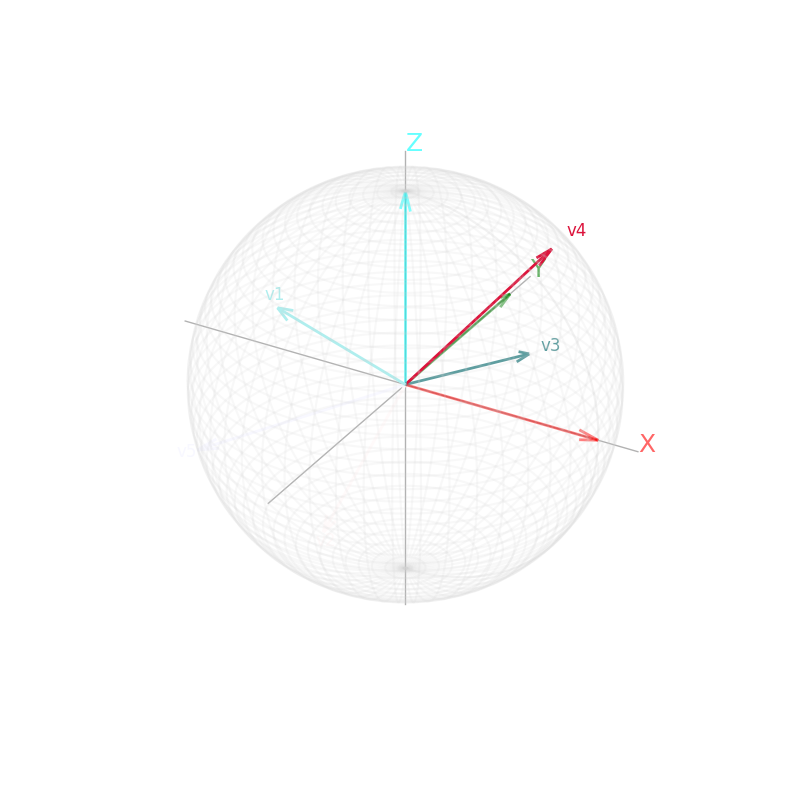

In [79]:
# Test plotting
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
bloch_sphere(ax)

# Plot random vectors
random_vectors = [np.random.uniform(-1, 1, 3) for _ in range(5)]
vectors = [vec / np.linalg.norm(vec) for vec in random_vectors]
labels = [f'v{i+1}' for i in range(len(vectors))]
plot_bloch_vectors(vectors=vectors, labels=labels, ax=ax)
plt.show()

# Part 1 — From Qubit States to Bloch Vectors

In this first part we review the Bloch representation of qubit density matrices.

Any qubit state can be written as:
$$
\rho = \frac{1}{2}\left( I + xX + yY + zZ \right).
$$

---
**Question:**

For any density matrix $\rho$, how can we extract the Bloch vector components $x,y,z$?

**Answer:**

*A proper but short mathematical derivation is expected.*
$$Tr(\rho*X) = Tr(\frac{1}{2}\left( I + xX + yY + zZ \right) * X) = Tr(\frac{1}{2}\left( X + x*identity - iyZ + izY \right)) = 1/2*(0+2*x-0i+0i) = x 
$$ 

Same reasoning for the y and z.

---

## Exercise 1.1 — Implement `rho_to_bloch` and `bloch_to_rho`

Write a function `rho_to_bloch(rho: np.ndarray) -> np.ndarray` that takes a $2\times2$ density matrix and returns the Bloch vector $(x,y,z)$ as a 1d numpy array.
Conversely, implement a function `bloch_to_rho(r: np.ndarray) -> np.ndarray` that takes a Bloch vector and returns the corresponding density matrix.

Test your functions for the following states:
- The pure state $|0\rangle$ (should map to the Bloch vector $(0,0,1)$)
- The pure state $|1\rangle$ (should map to the Bloch vector $(0,0,-1)$)
- The maximally mixed state $\frac{I}{2}$ (should map to the Bloch vector $(0,0,0)$)
- A random mixed state (verify that converting to Bloch vector and back yields the same density matrix)
- Plot the corresponding Bloch vectors on the Bloch sphere.

In [80]:
def rho_to_bloch(rho: np.ndarray) -> np.ndarray:
    """
    Convert a density matrix to its corresponding Bloch vector.
    :param rho: 2x2 density matrix
    :return: Bloch vector (x, y, z)
    """
    bloch_vector = [np.trace(rho@X, dtype=float), np.trace(rho@Y, dtype=float), np.trace(rho@Z, dtype=float)]
    return np.array(bloch_vector)

In [81]:
def bloch_to_rho(r: np.ndarray) -> np.ndarray:
    """
    Convert a Bloch vector to its corresponding density matrix.
    :param r: Bloch vector (x, y, z)
    :return: 2x2 density matrix
    """
    x,y,z = r
    return np.array(1/2 * (I + x*X + y*Y + z*Z))

State: |0>, Bloch Vector: [0. 0. 1.]
Reconstructed Density Matrix:
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

State: |1>, Bloch Vector: [ 0.  0. -1.]
Reconstructed Density Matrix:
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

State: I/2, Bloch Vector: [0. 0. 0.]
Reconstructed Density Matrix:
[[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

State: Random Mixed, Bloch Vector: [0.4 0.  0.4]
Reconstructed Density Matrix:
[[0.7+0.j 0.2+0.j]
 [0.2+0.j 0.3+0.j]]


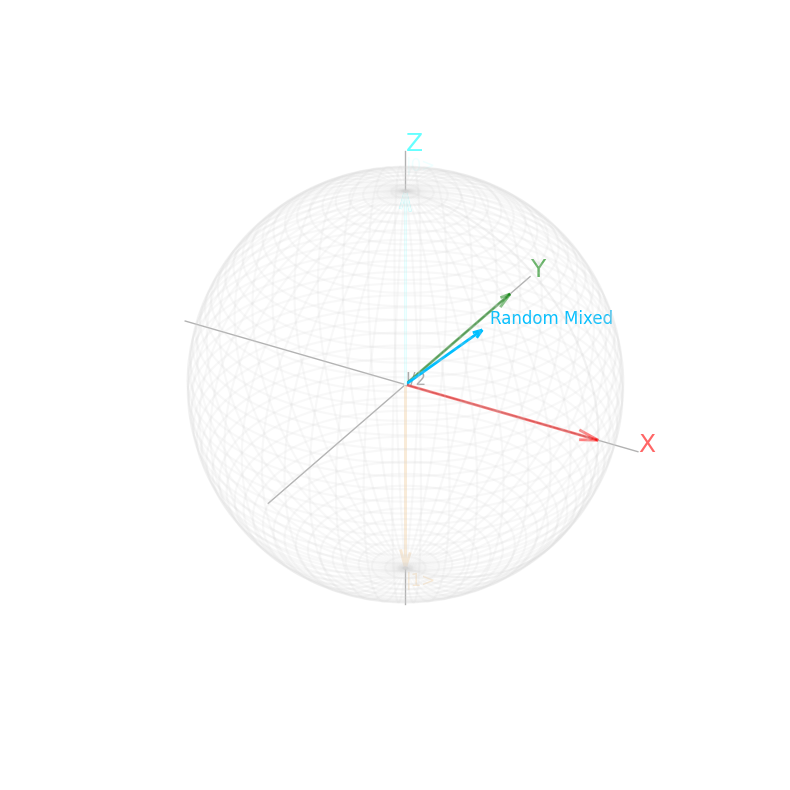

In [82]:
# Test the functions
test_states = {
    "|0>": rho0,
    "|1>": rho1,
    "I/2": 0.5 * I,
    "Random Mixed": np.array([[0.7, 0.2], [0.2, 0.3]], dtype=complex)
}
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
bloch_sphere(ax)
for label, rho in test_states.items():
    bloch_vec = rho_to_bloch(rho)
    print(f"State: {label}, Bloch Vector: {bloch_vec}")
    rho_reconstructed = bloch_to_rho(bloch_vec)
    print(f"Reconstructed Density Matrix:\n{rho_reconstructed}\n")
    plot_bloch_vectors([bloch_vec], [label], ax)
plt.show()

# Part 2 — Physical Decoherence Channels (T₁ and T₂)

Real qubits in nature undergo noisy dynamics due to coupling with the environment.

We will study three important channels:

### 1. Phase Damping (Dephasing)
Affects only transverse components:
$$
x(t) = e^{-t/T_2} x(0), \quad
y(t) = e^{-t/T_2} y(0), \quad
z(t) = z(0).
$$

### 2. Amplitude Damping
Models energy relaxation to the ground state $|0\rangle$:
$$
z(t) = e^{-t/T_1} z(0) + \big(1 - e^{-t/T_1}\big),
$$
$$
x(t),\,y(t) \propto e^{-t/(2T_1)}.
$$

### 3. Depolarizing Noise
Contracts the Bloch sphere uniformly:
$$
\vec{r}(t) = (1 - p)\,\vec{r}(0).
$$

---

## Exercise 2.1 — Implement the three functions

Write functions:

- `phase_damping(r: np.ndarray, t: float, T2: float) -> np.ndarray`
- `amplitude_damping(r: np.ndarray, t: float, T1: float) -> np.ndarray`
- `depolarizing_noise(r: np.ndarray, p: float) -> np.ndarray`

Each takes a Bloch vector and returns a *new* Bloch vector.

In [83]:
def phase_damping(r: np.ndarray, t: float, T2: float) -> np.ndarray:
    """
    Apply phase damping to a Bloch vector.
    :param r: Bloch vector (x, y, z)
    :param t: time
    :param T2: phase damping time constant
    :return: new Bloch vector after phase damping
    """
    x,y,z = r
    new_x = np.exp(-t/T2)*x
    new_y = np.exp(-t/T2)*y
    new_z = z
    return np.array([new_x, new_y, new_z], dtype=float)

In [84]:
def amplitude_damping(r: np.ndarray, t: float, T1: float) -> np.ndarray:
    """
    Apply amplitude damping to a Bloch vector.
    :param r: Bloch vector (x, y, z)
    :param t: time
    :param T1: amplitude damping time constant
    :return: new Bloch vector after amplitude damping
    """
    x,y,z = r
    new_x = np.exp(-t/(2*T1))*x
    new_y = np.exp(-t/(2*T1))*y
    new_z = np.exp(-t/T1)*z + (1- np.exp(-t/T1))
    return np.array([new_x, new_y, new_z], dtype=float)

In [85]:
def depolarizing_noise(r: np.ndarray, p: float) -> np.ndarray:
    """
    Apply depolarizing noise to a Bloch vector.
    :param r: Bloch vector (x, y, z)
    :param p: depolarizing probability
    :return: new Bloch vector after depolarizing noise
    """
    new_r = (1-p) * r
    return new_r

## Exercise 2.2 — Qualitative predictions

Before running anything:

1. Qualitatively speaking, how each channel acts on a Bloch vector.
2. Which channels preserve $z$? Which preserve the purity?
3. Which channel drives the qubit toward the center of the sphere? Why?

Give your answers in the box below.

**Answer:**

_Type your answers here._
1. Phase damping squeezes the bloch vector towards the z-axis, x and y decay while z stays constant. Amplitude damping pulls the bloch vector towards z=+1, it pulls the vector into the "north pole". Depolarizing just shrinks the vector towards the center.
2. Phase damping preserves Z since z(t)=z(0). None of them preserve purity:
3. Depolarizing Noise because every component is reduced, hence the norm of the vector is reduced.

In [86]:
"""pure_state = np.array(ket0 @ ket0.conj().T, dtype=complex)
print("Trace of pure state: ", np.trace(pure_state))
print(pure_state)
print(rho_to_bloch(pure_state))
print(phase_damping(rho_to_bloch(pure_state),0.01,3.0))
print(bloch_to_rho(phase_damping(rho_to_bloch(pure_state),0.01,3.0)))
print("Trace after phase dumping: ", np.trace(bloch_to_rho(phase_damping(rho_to_bloch(pure_state),0.01,3.0))))
print("Trace after amplitude dumping: ", np.trace(bloch_to_rho(amplitude_damping(rho_to_bloch(pure_state),0.01,5.0))))
print("Trace after depolarizing noise: ", np.trace(bloch_to_rho(depolarizing_noise(rho_to_bloch(pure_state),0.3))))"""

'pure_state = np.array(ket0 @ ket0.conj().T, dtype=complex)\nprint("Trace of pure state: ", np.trace(pure_state))\nprint(pure_state)\nprint(rho_to_bloch(pure_state))\nprint(phase_damping(rho_to_bloch(pure_state),0.01,3.0))\nprint(bloch_to_rho(phase_damping(rho_to_bloch(pure_state),0.01,3.0)))\nprint("Trace after phase dumping: ", np.trace(bloch_to_rho(phase_damping(rho_to_bloch(pure_state),0.01,3.0))))\nprint("Trace after amplitude dumping: ", np.trace(bloch_to_rho(amplitude_damping(rho_to_bloch(pure_state),0.01,5.0))))\nprint("Trace after depolarizing noise: ", np.trace(bloch_to_rho(depolarizing_noise(rho_to_bloch(pure_state),0.3))))'

# Part 3 — Time Evolutions and Trajectories

You will now generate full trajectories of a Bloch vector under the three channels.

We use a helper function that constructs trajectories over a list of times.
You must write it.

---

## Exercise 3.1 — Implement `compute_trajectories(r0: np.ndarray, T1: float, T2: float, steps: int)`

For an initial Bloch vector `r0`, compute:

- `traj_phase` for times `np.linspace(start=0, stop=T2, num=steps)`
- `traj_amp`   for times `np.linspace(start=0, stop=T1, num=steps)`
- `traj_depol` for probabilities `np.linspace(start=0, stop=1, num=steps)`

Return the three lists of vectors.

In [87]:
def compute_trajectories(r0: np.ndarray, T1: float, T2: float, steps: int):
    """
    Compute trajectories of a Bloch vector under phase damping, amplitude damping, and depolarizing noise.
    :param r0: initial Bloch vector (x, y, z)
    :param T1: amplitude damping time constant
    :param T2: phase damping time constant
    :param steps: number of steps in the trajectory
    :return: traj_phase, traj_amp, traj_depol
    """
    times_phase = np.linspace(0, T2, steps)
    times_amp = np.linspace(0, T1, steps)
    probs_depol = np.linspace(0, 1, steps)

    traj_phase = [phase_damping(r0, t, T2) for t in times_phase]
    traj_amp = [amplitude_damping(r0, t, T1) for t in times_amp]
    traj_depol = [depolarizing_noise(r0, p) for p in probs_depol]

    return traj_phase, traj_amp, traj_depol

## Exercise 3.2 — Plot x(t), y(t), z(t)

Using your trajectories:

1. Plot the curves $x(t)$, $y(t)$, and $z(t)$ for each noise channel.
2. Compare the time scales of:

- decay of transverse components ($x$ and $y$),
- drift of $z$ toward +1,
- uniform contraction of all components.

Explain the physical origin of each behavior.

In [88]:
# Initial Bloch vector (example: random state with all components non-zero)
r0 = np.array([0.6, 0.8, 0.5])
# Ensure normalization
r0 = r0 / np.linalg.norm(r0)

T1 = 5.0  # Amplitude damping time constant
T2 = 3.0  # Phase damping time constant
steps = 100

In [89]:
# Compute trajectories
traj_phase, traj_amp, traj_depol = compute_trajectories(r0, T1, T2, steps)

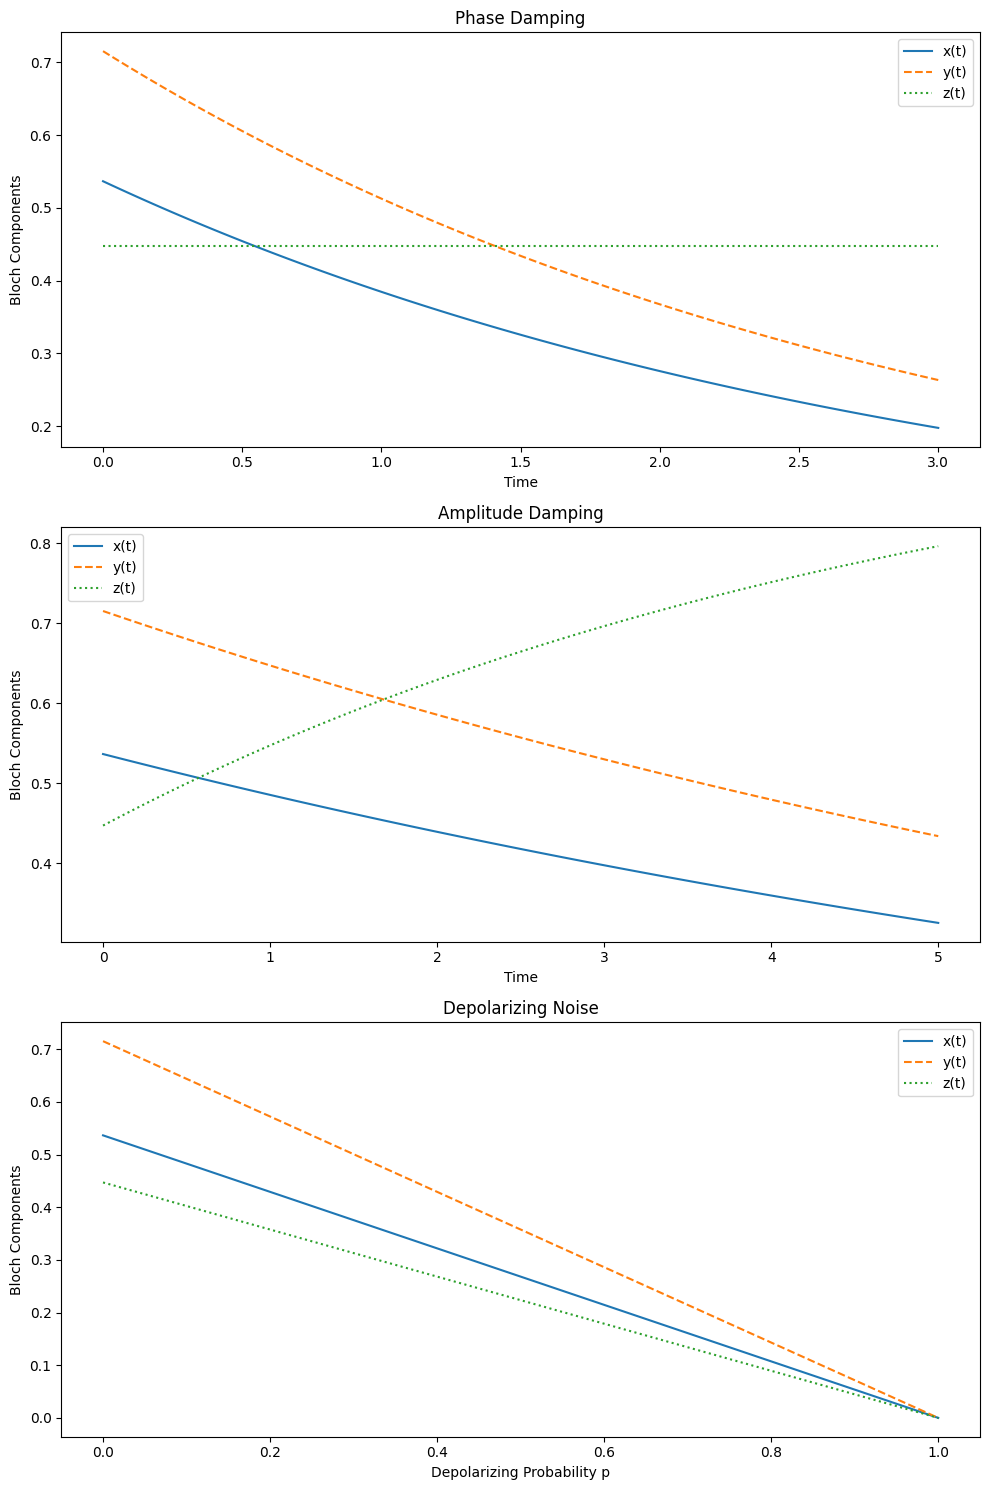

In [90]:
# Plotting the trajectories
times_phase = np.linspace(0, T2, steps)
times_amp = np.linspace(0, T1, steps)
probs_depol = np.linspace(0, 1, steps)
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

linestyle_x = '-'
linestyle_y = '--'
linestyle_z = ':'

# Phase Damping
axs[0].set_title('Phase Damping')
axs[0].plot(times_phase, [r[0] for r in traj_phase], label='x(t)', linestyle=linestyle_x)
axs[0].plot(times_phase, [r[1] for r in traj_phase], label='y(t)', linestyle=linestyle_y)
axs[0].plot(times_phase, [r[2] for r in traj_phase], label='z(t)', linestyle=linestyle_z)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Bloch Components')
axs[0].legend()

# Amplitude Damping
axs[1].set_title('Amplitude Damping')
axs[1].plot(times_amp, [r[0] for r in traj_amp], label='x(t)', linestyle=linestyle_x)
axs[1].plot(times_amp, [r[1] for r in traj_amp], label='y(t)', linestyle=linestyle_y)
axs[1].plot(times_amp, [r[2] for r in traj_amp], label='z(t)', linestyle=linestyle_z)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Bloch Components')
axs[1].legend()

# Depolarizing Noise
axs[2].set_title('Depolarizing Noise')
axs[2].plot(probs_depol, [r[0] for r in traj_depol], label='x(t)', linestyle=linestyle_x)
axs[2].plot(probs_depol, [r[1] for r in traj_depol], label='y(t)', linestyle=linestyle_y)
axs[2].plot(probs_depol, [r[2] for r in traj_depol], label='z(t)', linestyle=linestyle_z)
axs[2].set_xlabel('Depolarizing Probability p')
axs[2].set_ylabel('Bloch Components')
axs[2].legend()

plt.tight_layout()
plt.show()

**Answer:**

_Type your answers here._

- Depolarizing noise:
With some probability you apply a random Pauli error, so the Bloch vector is averaged over different directions. This reduces the coordinates in all bases equally and drives the state into the maximally mixed state.

# Part 4 — Visualizing Trajectories on the Bloch Sphere

We now visualize the three trajectories on a Bloch sphere using an animation.

You are **not** asked to implement the animation code yourself. The code is given in `bloch_trajectories.py`. Make sure to complete the script with the defined functions above for the channels and run it to see the animations. Take the time to read and understand the code. Variable names are as explicit as possible, and the code should be well commented to understand each step.

Ensure you have the `bloch_trajectories.py` file in the same directory as this notebook. Run the script directly instead of importing it, as it contains animation code that can be executed in the main context.

Can you observe the expected behaviors for each channel on the Bloch sphere?

**Answer:**

1. Phase damping squeezes the bloch vector towards the z-axis, x and y decay while z stays constant. 
2. Amplitude damping pulls the bloch vector towards z=+1, it pulls the vector into the "north pole". 
3. Depolarizing just shrinks the vector towards the center.

# Part 5 — Repeated Imperfect Quantum Gates

Simulation algorithms often involve applying many quantum gates in sequence. But, they are often prone to errors.
Let us simulate the effect of repeated imperfect quantum gates on a qubit's state, to understand how errors accumulate over time. We will look at the trajectory on the Bloch sphere, starting from the states $|0\rangle$, $|1\rangle$, $|+\rangle$ and $|i\rangle$.

To model this, we can consider that a perfect gate is followed by a noise channel. For example, taking a gate $U$, and a set of Kraus operators representing a noise channel $\{K_i\}$, the state evolves as:
$$
\varepsilon(\rho) = \sum_i K_i U \rho U^\dagger K_i^\dagger.
$$

## Common noise model

We just saw three types of noise channels: phase damping, amplitude damping, and depolarizing noise.
In the previous expression, the Kraus operators $\{K_i\}$ can be chosen to represent any of these channels:
- **Depolarizing noise** with probability $p$, consist of applying a random Pauli operator $X$, $Y$, or $Z$ with probability $p/3$ each, or doing nothing (identity) with probability $1-p$.
- **Phase damping** with probability $\gamma$, has Kraus operators:
  $$
  K_0 = \sqrt{1 - \gamma} I, \quad K_1 = \sqrt{\gamma} |0\rangle\langle0|, \quad K_2 = \sqrt{\gamma} |1\rangle\langle1|.
  $$
- **Amplitude damping** with probability $\gamma$, models the decay of the excited state $|1\rangle$ to the ground state $|0\rangle$:
  $$
  K_0 = \begin{pmatrix} 1 & 0 \\ 0 & \sqrt{1 - \gamma} \end{pmatrix}, \quad K_1 = \begin{pmatrix} 0 & \sqrt{\gamma} \\ 0 & 0 \end{pmatrix}.
  $$

## Repeated application

For a sequence of $N$ gates, each followed by a noise channel, the state evolves as:
$$
\rho_N = \varepsilon_N \circ \varepsilon_{N-1} \circ \cdots \circ \varepsilon_1 (\rho_0),
$$

where each $\varepsilon_i$ represents the application of a gate followed by noise.

---
## Task

You will represent for each of the four states, the effect of repeated imperfect quantum gates on the Bloch sphere.
We consider first a sequence of $N$ $X$-gates, each followed by a noise channel. Your script should be flexible, by allowing the use of different gates (whether it is a sequence of the same gate, or alternating gates). Structure your code as follows:

1. Define the initial states: $|0\rangle$, $|1\rangle$, $|+\rangle$ and $|i\rangle = \frac{|0\rangle + i|1\rangle}{\sqrt{2}}$.
2. Apply the noisy gate sequences for a number of steps (e.g., 50, 100, 300, etc.).
3. Visualize the trajectories on the Bloch sphere using an animation, and provide in the notebook the static plot as well.

The script `bloch_trajectories.py` is provided to help you visualize the trajectories of each individual channel. Your goal is to write a new script `bloch_noisy_gates.py`, to visualize the effect of repeated imperfect quantum gates on the Bloch sphere.

In [91]:
# Note: The implementation of the script `bloch_noisy_gates.py` is not shown here.
# You should create this script in a separate file as per the instructions above.
# It is recommended to define separated functions for applying noisy gates and for visualizing the trajectories, just like in `bloch_trajectories.py`,
# such that you can simply call `plot_trajectories` for example, and you just need to provide the list of initial states.

---
**Bonus:**

Consider now a combination of noise channels after each gate, for example, first amplitude damping followed by phase damping.
Just like before, visualize the resulting trajectories on the Bloch sphere. You can also define combinations of different gates (e.g., alternating between $X$ and $Y$ gates).